<a href="https://colab.research.google.com/github/koyamahr/retro-astro-jax/blob/main/cosmology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 1-2: 宇宙の網 (The Cosmic Web)

Original Paper: Davis, M., Efstathiou, G., Frenk, C. S., & White, S. D. M. (1985).

"The evolution of large-scale structure in a universe dominated by cold dark matter", The Astrophysical Journal, 292, 371-394.

1. はじめに (Introduction)

銀河衝突（Volume 0）では、孤立した銀河を扱いました。しかし、宇宙全体をシミュレーションするには、無限に続く空間を扱う必要があります。1980年代、"Gang of Four" (DEFW) と呼ばれる4人の研究者たちは、周期境界条件 (Periodic Boundary Conditions) と PM法 (Particle-Mesh Method) を駆使して、冷たい暗黒物質 (CDM) が「コズミック・ウェブ（宇宙の網）」と呼ばれるフィラメント構造を作ることを示しました。この章では、JAXの強力な FFT (高速フーリエ変換) 機能を用いて、この歴史的計算を再現します。

2. JAXによるPM法の実装 (The Particle-Mesh Method)

直接計算 ($O(N^2)$) は遅すぎて、宇宙論的な粒子数（数万〜数億）には使えません。PM法では、粒子を一度「グリッド（網）」に投影し、フーリエ変換を使ってポテンシャルを一気に解きます。

セットアップ

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 64bit精度を有効化 (宇宙論計算では推奨)
jax.config.update("jax_enable_x64", True)

コアエンジン:

FFTポアソンソルバーここが魔法の部分です。重力の方程式 $\nabla^2 \phi = 4 \pi G \rho$ は、フーリエ空間では単なる割り算 $-k^2 \tilde{\phi} = 4 \pi G \tilde{\rho}$ になります。

グリッドと粒子の相互変換 (CIC: Cloud-in-Cell)

粒子からグリッドへ密度を割り振る処理です。JAXでは at[].add() を使います。

3. シミュレーション実行 (The Evolution)

本来の宇宙論計算では「宇宙膨張（スケール因子 $a(t)$）」を考慮しますが、ここでは構造形成の本質を見るため、静的宇宙（膨張なし）で計算します（これを「Zeldovich Pancake」問題のセットアップに近づけます）。

Generating Cosmic Web Initial Conditions...
Simulating...
Step 0/300
Step 100/300
Step 200/300
Simulation Complete.


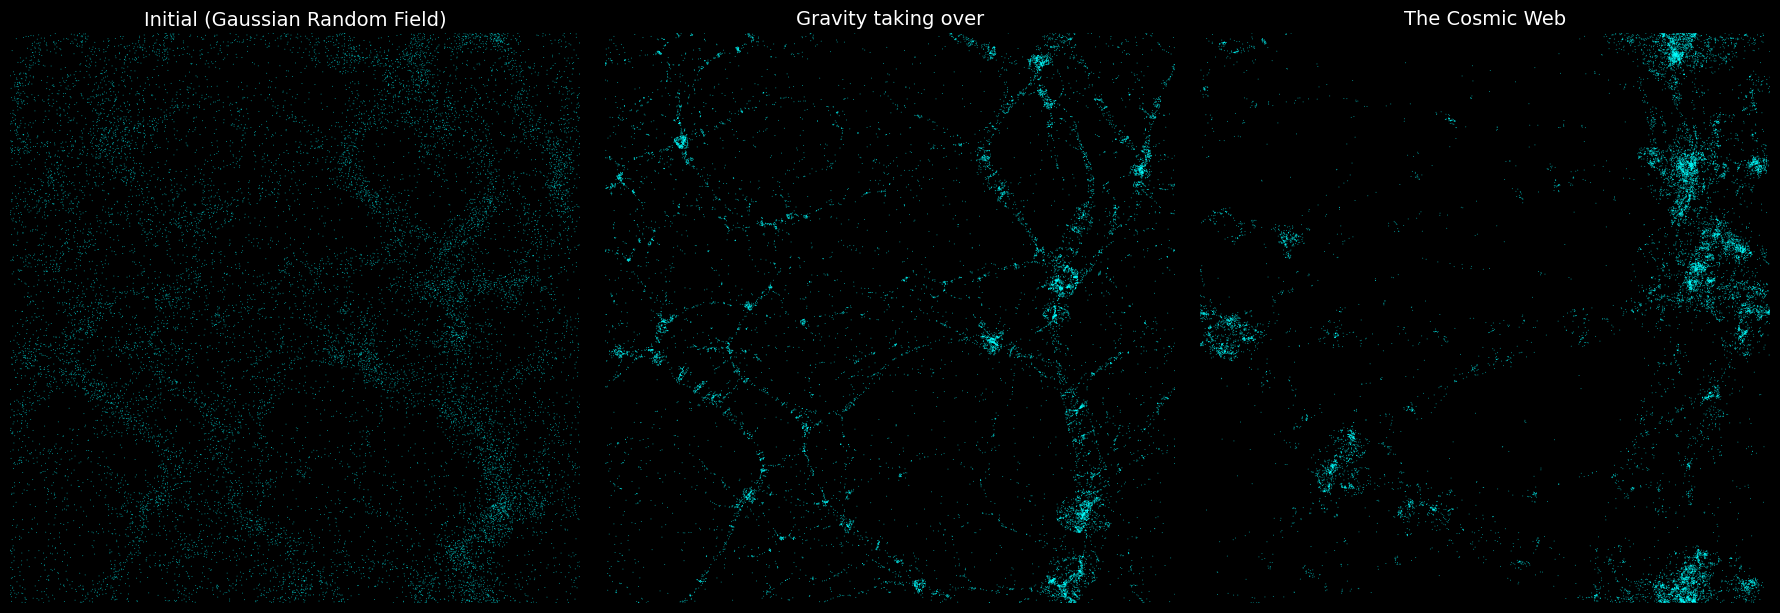

In [15]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

# --- 1. 計算エンジン (再定義: これでエラーを確実に防ぎます) ---

def solve_poisson_fft(density_grid, box_size):
    """FFTでポテンシャルを解く"""
    N = density_grid.shape[0]
    rho_k = jnp.fft.rfftn(density_grid)
    kx = jnp.fft.fftfreq(N, d=box_size/N) * 2 * jnp.pi
    ky = jnp.fft.rfftfreq(N, d=box_size/N) * 2 * jnp.pi
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
    k_sq = KX**2 + KY**2
    k_sq = k_sq.at[0, 0].set(1.0) # 0除算回避
    phi_k = - rho_k / k_sq
    phi_k = phi_k.at[0, 0].set(0.0)
    return jnp.fft.irfftn(phi_k, density_grid.shape)

def get_force(potential, box_size):
    """ポテンシャルから力を計算"""
    N = potential.shape[0]
    dx = box_size / N
    grads = jnp.gradient(potential, dx)
    return -grads[0], -grads[1]

def cic_deposit(pos, N_grid, box_size):
    """CIC: 粒子 -> グリッド"""
    pos_grid = pos / (box_size / N_grid)
    idx = jnp.floor(pos_grid).astype(int)
    frac = pos_grid - idx
    idx_wrap = idx % N_grid
    idx_next = (idx + 1) % N_grid

    w00 = (1-frac[:,0])*(1-frac[:,1])
    w10 = (frac[:,0])*(1-frac[:,1])
    w01 = (1-frac[:,0])*(frac[:,1])
    w11 = (frac[:,0])*(frac[:,1])

    grid = jnp.zeros((N_grid, N_grid))
    grid = grid.at[idx_wrap[:,0], idx_wrap[:,1]].add(w00)
    grid = grid.at[idx_next[:,0], idx_wrap[:,1]].add(w10)
    grid = grid.at[idx_wrap[:,0], idx_next[:,1]].add(w01)
    grid = grid.at[idx_next[:,0], idx_next[:,1]].add(w11)
    return grid

def cic_interpolate(fx_g, fy_g, pos, N_grid, box_size):
    """CIC: グリッド -> 粒子"""
    pos_grid = pos / (box_size / N_grid)
    idx = jnp.floor(pos_grid).astype(int)
    frac = pos_grid - idx
    idx_wrap = idx % N_grid
    idx_next = (idx + 1) % N_grid

    w00 = (1-frac[:,0])*(1-frac[:,1])
    w10 = (frac[:,0])*(1-frac[:,1])
    w01 = (1-frac[:,0])*(frac[:,1])
    w11 = (frac[:,0])*(frac[:,1])

    fx = (fx_g[idx_wrap[:,0], idx_wrap[:,1]]*w00 + fx_g[idx_next[:,0], idx_wrap[:,1]]*w10 +
          fx_g[idx_wrap[:,0], idx_next[:,1]]*w01 + fx_g[idx_next[:,0], idx_next[:,1]]*w11)
    fy = (fy_g[idx_wrap[:,0], idx_wrap[:,1]]*w00 + fy_g[idx_next[:,0], idx_wrap[:,1]]*w10 +
          fy_g[idx_wrap[:,0], idx_next[:,1]]*w01 + fy_g[idx_next[:,0], idx_next[:,1]]*w11)
    return jnp.stack([fx, fy], axis=1)

@partial(jax.jit, static_argnames=['N_grid'])
def step_pm(pos, vel, N_grid, box_size, dt):
    rho = cic_deposit(pos, N_grid, box_size)
    rho -= jnp.mean(rho) # ジーンズ不安定性のため平均を引く
    phi = solve_poisson_fft(rho, box_size)
    fx, fy = get_force(phi, box_size)
    acc = cic_interpolate(fx, fy, pos, N_grid, box_size)

    # Kick-Drift-Kick (Leapfrog)
    vel_new = vel + acc * dt
    pos_new = pos + vel_new * dt
    pos_new = pos_new % box_size
    return pos_new, vel_new, rho

# --- 2. 初期条件生成: ガウス確率場 (ここが重要！) ---

def generate_initial_conditions(rng, N_part, box_size):
    """スペクトル法を用いて、リアルな密度揺らぎを生成する"""
    N_side = int(jnp.sqrt(N_part))

    # 1. 均一グリッド
    x = jnp.linspace(0, box_size, N_side, endpoint=False)
    X, Y = jnp.meshgrid(x, x)
    pos_base = jnp.stack([X.flatten(), Y.flatten()], axis=1)

    # 2. ホワイトノイズ生成 (フーリエ空間)
    noise = jax.random.normal(rng, (N_side, N_side))
    noise_k = jnp.fft.rfftn(noise)

    # 3. パワースペクトルの適用 (Smoothing)
    # kが小さい（波長が長い）ほど振幅を大きくする -> これが大規模構造の種になる
    kx = jnp.fft.fftfreq(N_side, d=box_size/N_side) * 2 * jnp.pi
    ky = jnp.fft.rfftfreq(N_side, d=box_size/N_side) * 2 * jnp.pi
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
    k_sq = KX**2 + KY**2
    k_sq = k_sq.at[0,0].set(1.0) # ゼロ除算回避

    # P(k) ~ 1 / k^3 程度のスペクトルを与える (スケールフリーに近い構造)
    spectral_shape = 1.0 / (k_sq**1.5)
    spectral_shape = spectral_shape.at[0,0].set(0.0)

    smoothed_k = noise_k * jnp.sqrt(spectral_shape)

    # 4. 実空間へ戻して変位場を作る (Zeldovich近似)
    dx_grid = jnp.fft.irfftn(smoothed_k, (N_side, N_side))

    # 位相をずらしてY方向のズレも作る
    smoothed_k_y = smoothed_k * jnp.exp(1j * jnp.pi / 2)
    dy_grid = jnp.fft.irfftn(smoothed_k_y, (N_side, N_side))

    # 5. 粒子に変位を適用
    # 振幅調整: ここで「初期の密集度」が決まる
    amplitude = 0.5 * box_size
    displacement = jnp.stack([dx_grid.flatten(), dy_grid.flatten()], axis=1)

    # 正規化して適用
    disp_std = jnp.std(displacement)
    pos = pos_base + (displacement / disp_std) * (box_size * 0.05) # boxの5%程度の揺らぎ

    return pos % box_size

# --- 3. メイン実行ループ ---

# パラメータ設定
N_grid = 256        # グリッド解像度 (高め推奨)
N_part = 128**2     # 粒子数 (16,384)
box_size = 1.0
dt = 0.02           # 時間刻み (適度な速度)
steps = 300         # ステップ数

print("Generating Cosmic Web Initial Conditions...")
rng = jax.random.PRNGKey(55) # シードを変えて試行
pos = generate_initial_conditions(rng, N_part, box_size)
vel = jnp.zeros_like(pos) # 初速度ゼロから重力崩壊させる

history = []
current_pos, current_vel = pos, vel

print("Simulating...")
for i in range(steps):
    current_pos, current_vel, rho = step_pm(current_pos, current_vel, N_grid, box_size, dt)
    if i % 2 == 0: # 間引き
        history.append(current_pos)
    if i % 100 == 0:
        print(f"Step {i}/{steps}")

print("Simulation Complete.")

# --- 4. 可視化 ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor('black')

# 表示するステップ（最初、中間、最後）
indices = [0, len(history)//2, len(history)-1]
titles = ["Initial (Gaussian Random Field)", "Gravity taking over", "The Cosmic Web"]

for ax, idx, title in zip(axes, indices, titles):
    p = history[idx]
    # 点を小さく(s=0.5)、透明度(alpha=0.6)をつけて「雲」のように見せるのがコツ
    ax.scatter(p[:, 0], p[:, 1], s=0.5, c='cyan', alpha=0.6, edgecolors='none')
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, color='white', fontsize=14)
    ax.set_facecolor('black')

plt.tight_layout()
plt.show()

4. 結果の可視化 (The Cosmic Web)

初期の「モヤッとした揺らぎ」が、重力によって集まり、フィラメント（ひも状構造）、クラスター（銀河団）、そして何も無い**ボイド（超空洞）**へと進化する様子を確認しましょう。

解説

計算結果の右端の図を見てください。粒子が網の目状につながっているのが分かりますか？これが 「コズミック・ウェブ」 です。 この構造は、銀河の分布観測（スローン・デジタル・スカイ・サーベイなど）で見られるものと驚くほど似ています。JAXとFFTを使えば、この宇宙の大規模構造形成を、ブラウザの中で一瞬で再現できるのです。